# End to End Structured Data Modeling with ANN


In [ ]:
import keras
import tensorflow as tf
print("Keras Current Version:", keras.__version__, "Tensorflow Current Version:", tf.__version__)

Keras Current Version: 3.3.3 Tensorflow Current Version: 2.16.1


In [ ]:
# !pip uninstall tf-keras

In [ ]:
# !pip install tensorflow==2.16.1

# Data Preparation

## Imports and Settings

In [ ]:
import numpy as np
import pandas as pd
from joblib import dump, load
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)

# Ortam ayarları ve veri yükleme
data_path = '/content/diabetes.csv'

## Normalizing Inputs and Save the Scaler

In [ ]:
def preprocess_data(filepath):
    data = pd.read_csv(filepath)
    scaler = StandardScaler()
    X = scaler.fit_transform(data.drop('Outcome', axis=1))
    y = data['Outcome'].values
    dump(scaler, 'scaler.joblib')
    return X, y

In [ ]:
X, y = preprocess_data(data_path)

## Train Validation and Tensorflow Dataset

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def prepare_datasets(X_train, X_val, y_train, y_val, batch_size=None):

    if batch_size is None:
        batch_size = len(X_train)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, val_dataset

In [ ]:
train_ds, val_ds = prepare_datasets(X_train, X_val, y_train, y_val)

In [ ]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Modeling


## Build the Model

In [ ]:
model = Sequential([
    Input(shape=(train_ds.element_spec[0].shape[1],)),

    Dense(50, activation='relu', kernel_regularizer=l2(0.001)),

    BatchNormalization(),

    Dropout(0.5),

    Dense(1, activation='sigmoid')
])


In [ ]:
optimizer = SGD(learning_rate=0.01, momentum=0.0)

model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy", "AUC"])

## Callbacks

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True)


model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

## Model Training

In [ ]:
history = model.fit(train_ds,

            epochs=1000,

            validation_data=val_ds,

            verbose=2,

            callbacks=[early_stopping, model_checkpoint])

In [ ]:
model.get_config()

In [ ]:
for layer in model.layers:
    config = layer.get_config()
    print(f"Layer type: {type(layer).__name__}")
    print("Initializer for weights:", config.get('kernel_initializer'))


Layer type: Dense
Initializer for weights: {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}
Layer type: BatchNormalization
Initializer for weights: None
Layer type: Dropout
Initializer for weights: None
Layer type: Dense
Initializer for weights: {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}


## Evaluating Model Results


### Best Epoch and Training History

In [ ]:
def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

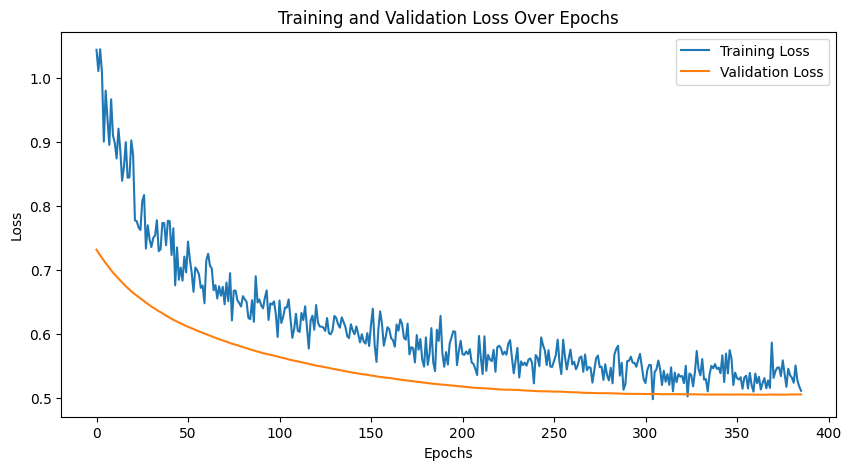

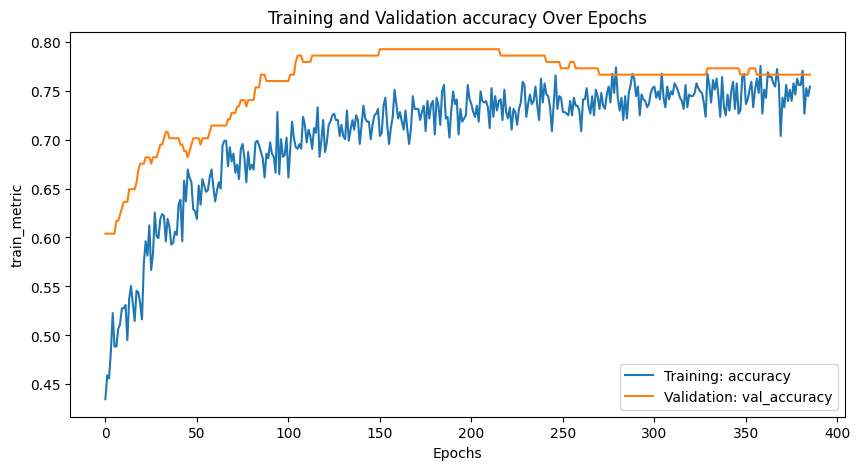

In [ ]:
plot_training_history(history)

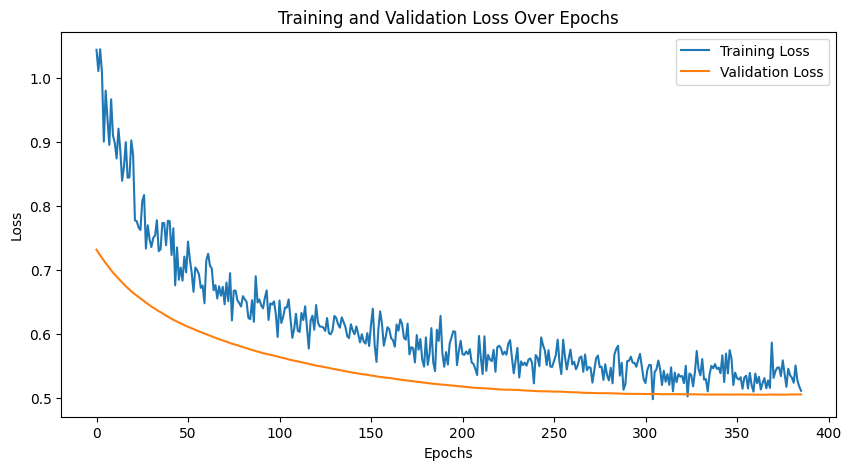

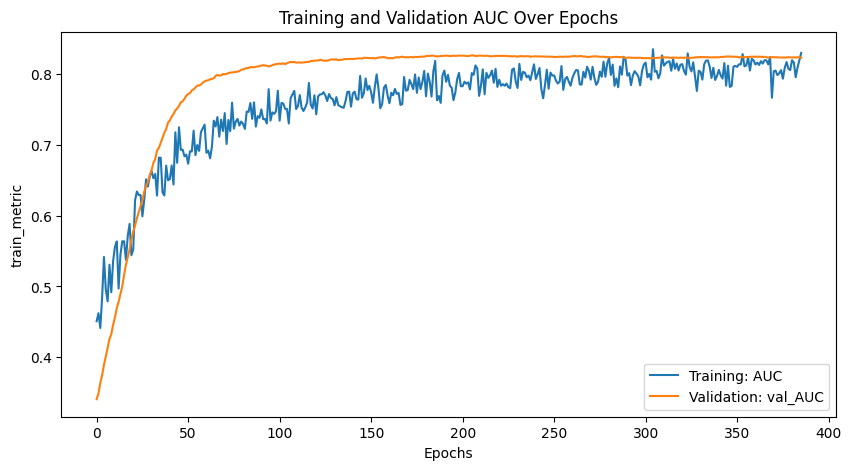

In [ ]:
plot_training_history(history, train_metric="AUC", val_metric="val_AUC")

In [ ]:
def get_best_epoch_details(history):

    val_losses = history.history['val_loss']

    min_val_loss_index = val_losses.index(min(val_losses))

    best_epoch = min_val_loss_index + 1

    epoch_details = {}
    for key in history.history.keys():
        epoch_details[key] = history.history[key][min_val_loss_index]

    epoch_details['best_epoch'] = best_epoch
    return epoch_details


In [ ]:
best_epoch_details = get_best_epoch_details(history)
print(f"Best epoch details: {best_epoch_details}")

Best epoch details: {'AUC': 0.8192838430404663, 'accuracy': 0.757328987121582, 'loss': 0.531046986579895, 'val_AUC': 0.8238751292228699, 'val_accuracy': 0.7662337422370911, 'val_loss': 0.5050963163375854, 'best_epoch': 366}


### Loading the Best Model

In [ ]:
best_model = load_model('best_model.keras')

In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │             450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 703 (2.75 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 100 (400.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
best_model.get_config()

### Weights and Biases


In [ ]:
def print_model_weights_biases(model, show_values=False):
    for layer in model.layers:
        weights_biases = layer.get_weights()
        if weights_biases:
            print(f"Layer: {layer.name}")
            for i, wb in enumerate(weights_biases):
                if i == 0:
                    type_wb = "Weights"
                else:
                    type_wb = "Biases"
                print(f"  {type_wb} (Count: {wb.size}):")
                print(f"    Min: {np.min(wb):.4f}")
                print(f"    Max: {np.max(wb):.4f}")
                print(f"    Mean: {np.mean(wb):.4f}")
                print(f"    Std Dev: {np.std(wb):.4f}")
                if show_values:
                    print(f"    Values: {wb}")
        else:
            print(f"Layer {layer.name} has no weights or biases.")

In [ ]:
print_model_weights_biases(best_model, show_values = False)

Layer: dense
  Weights (Count: 400):
    Min: -0.3412
    Max: 0.3664
    Mean: -0.0024
    Std Dev: 0.1867
  Biases (Count: 50):
    Min: -0.0447
    Max: 0.0445
    Mean: -0.0006
    Std Dev: 0.0196
Layer: batch_normalization
  Weights (Count: 50):
    Min: 0.9579
    Max: 1.0028
    Mean: 0.9885
    Std Dev: 0.0124
  Biases (Count: 50):
    Min: -0.0909
    Max: 0.0759
    Mean: 0.0058
    Std Dev: 0.0504
  Biases (Count: 50):
    Min: 0.0865
    Max: 0.2925
    Mean: 0.1965
    Std Dev: 0.0437
  Biases (Count: 50):
    Min: 0.0492
    Max: 0.2392
    Mean: 0.1218
    Std Dev: 0.0422
Layer dropout has no weights or biases.
Layer: dense_1
  Weights (Count: 50):
    Min: -0.2261
    Max: 0.3479
    Mean: -0.0104
    Std Dev: 0.1518
  Biases (Count: 1):
    Min: -0.2849
    Max: -0.2849
    Mean: -0.2849
    Std Dev: 0.0000


# Prediction

## Loading Model and Scaler Object

In [ ]:
scaler = load('/content/scaler.joblib')

diabetes_model = load_model('/content/best_model.keras')

## New Observation

In [ ]:
new_data = np.array([[6, 148, 72, 35, 0, 33.6, 0.627, 50]])

scaled_data = scaler.transform(new_data)


## Prediction

In [ ]:
prediction = diabetes_model.predict(scaled_data)

predicted_outcome = (prediction > 0.5).astype(int)

print("Class Probability:", prediction)
print("Class Prediction:", predicted_outcome)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Class Probability: [[0.7420982]]
Class Prediction: [[1]]


## Prediction with TensorFlow DataSets

In [ ]:
data_path = '/content/diabetes.csv'
diabetes_data = pd.read_csv(data_path)

In [ ]:
def random_samples(scaler, data, num_samples=100):
    X = data.drop('Outcome', axis=1)
    X_scaled = scaler.fit_transform(X)
    new_dataset = tf.data.Dataset.from_tensor_slices((X_scaled)).batch(len(X))
    return new_dataset

In [ ]:
random_samples = random_samples(scaler, diabetes_data)

In [ ]:
random_samples

<_BatchDataset element_spec=TensorSpec(shape=(None, 8), dtype=tf.float64, name=None)>

In [ ]:
diabetes_model.predict(random_samples)[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


array([[0.7420982 ],
       [0.07390869],
       [0.84527   ],
       [0.05396774],
       [0.8286767 ],
       [0.18067032],
       [0.09407356],
       [0.55042696],
       [0.89516586],
       [0.06217242]], dtype=float32)